# [WIP] Generate training examples in batch using t2t-datagen

### Overview

In this example we will be running the tensor2tensor t2t-datagen utility, together with a custom example generator, to generate a large collection of training examples that will be stored on disk (sharded and shuffled) in TFRecord protobuf format.

First we'll take a look at the input data followed by running the datagen step in batch on Kubeflow.

### Input data

Data produced by the previous data download step is organized on disk into two subdirectories, "meta" and "raw". We'll use this root path as input for the example generation step which knows to make use of metadata in meta/ in reference to image data in raw/

In [11]:
!ls /mnt/nfs-1/datasets/alleninst/mouse

meta  raw


In [18]:
!ls /mnt/nfs-1/datasets/alleninst/mouse/meta | head -n 10

1024x1024_path_manifest_100073360.csv
1024x1024_path_manifest_100095760.csv
1024x1024_path_manifest_100135040.csv
1024x1024_path_manifest_100150261.csv
1024x1024_path_manifest_100161018.csv
1024x1024_path_manifest_100243554.csv
1024x1024_path_manifest_100263892.csv
1024x1024_path_manifest_100268535.csv
1024x1024_path_manifest_100290701.csv
1024x1024_path_manifest_100292361.csv
ls: write error: Broken pipe


In [ ]:
## TODO: Should probably use HDF5

If you've performed the previous step you already have a large collection of 1024x1024 sub-images stored in this directory tree. Let's take a look at an example:

In [20]:
image_path="/mnt/nfs-1/datasets/alleninst/mouse/raw/100142550/102173162/1024x1024_63_102173162.jpg"

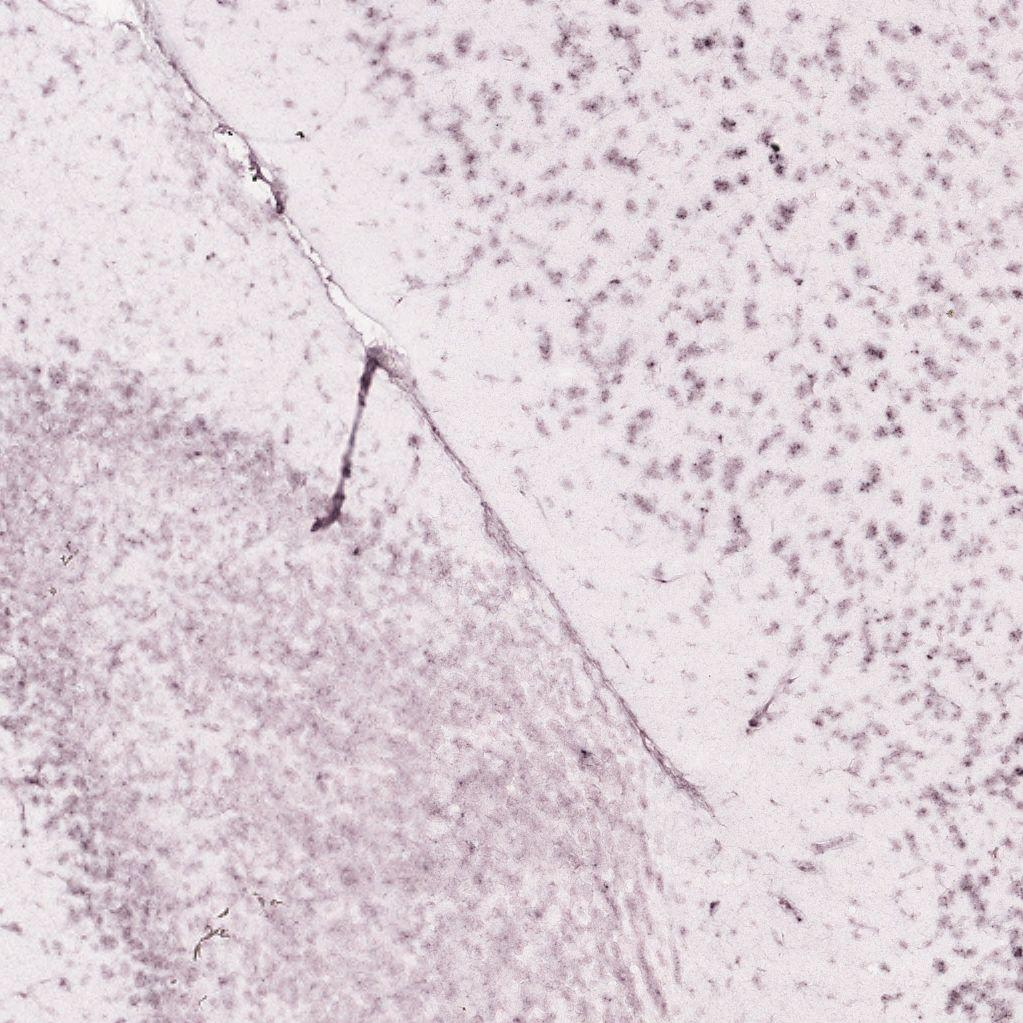

In [21]:
from IPython.display import Image 
Image(filename=image_path)

That's pretty awesome. But could we make it **more** awesome.

### Generating examples in batch

As described above the example generation step takes as input a path on disk sub-directories of which contain propperly-sized raw JPG examples. As you can see in the [example generator code](../py/generator.py) we'll be using a subclass of the tensor2tensor Problem class to define the properties and means of producing input and output examples. The training phase will then be a process of learning the parameters for a model that approximates a good function for mapping between these input/output pairs. Initially we'll be starting simple using an autoencoder to learn the identity mapping.

In [31]:
import os
APP_ROOT="/home/jovyan/work/examples-enhance/enhance"
LAUNCHER_PATH = os.path.join(APP_ROOT, "py", "launcher.py")

In [32]:
!python {LAUNCHER_PATH} --mode datagen --batch --no-wait \
    --app_root {APP_ROOT} --problem allen_brain_img2img \
    --tmp_dir=/mnt/nfs-1/datasets/alleninst/mouse

INFO:root:Parsed args: {'gcp_project': None, 'app_root': '/home/jovyan/work/examples-enhance/enhance', 'use_image': 'gcr.io/kubeflow-rl/common-base:0.0.1', 'batch': True, 'rebuild_base': False, 'volume_claim_id': 'nfs-1', 'no_wait': True, 'namespace': 'kubeflow', 'mode': 'datagen', 'problem': 'allen_brain_img2img', 'tmp_dir': '/mnt/nfs-1/datasets/alleninst/mouse'}
INFO:root:Staged app workdir to /mnt/nfs-1/studies/dev/enhance-0327-0114-82f1/staging
{'_batch': True,
 '_command': ['t2t-datagen',
              '--t2t_usr_dir',
              '/mnt/nfs-1/studies/dev/enhance-0327-0114-82f1/staging/py',
              '--problem',
              'allen_brain_img2img',
              '--tmp_dir',
              '/mnt/nfs-1/datasets/alleninst/mouse'],
 '_poll_and_check': False,
 'apiVersion': 'batch/v1',
 'kind': 'Job',
 'metadata': {'name': 'enhance-0327-0114-82f1', 'namespace': 'kubeflow'},
 'spec': {'backoffLimit': 4,
          'template': {'spec': {'containers': [{'args': ['t2t-datagen',
      

In [38]:
!kubectl logs -n kubeflow  enhance-0327-0114-82f1-447bj

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
INFO:tensorflow:Importing user module py from path /mnt/nfs-1/studies/dev/enhance-0327-0114-82f1/staging
INFO:tensorflow:Generating problems:
    allen:
      * allen_brain_img2img
INFO:tensorflow:Generating data for allen_brain_img2img.
INFO:tensorflow:Loaded case file paths (n=381352)


In [35]:
!date

Tue Mar 27 01:16:03 UTC 2018


### Dev

We can test whether this will run to completion with a dramatically smaller example, generated using the download step with num_slices=1 and images_per_slice=1 which should have ~30 subimage examples:

In [36]:
!python {LAUNCHER_PATH} --mode datagen --batch --no-wait \
    --app_root {APP_ROOT} --problem allen_brain_img2img \
    --tmp_dir=/mnt/nfs-1/datasets/alleninst/mouse-testing

INFO:root:Parsed args: {'gcp_project': None, 'app_root': '/home/jovyan/work/examples-enhance/enhance', 'use_image': 'gcr.io/kubeflow-rl/common-base:0.0.1', 'batch': True, 'rebuild_base': False, 'volume_claim_id': 'nfs-1', 'no_wait': True, 'namespace': 'kubeflow', 'mode': 'datagen', 'problem': 'allen_brain_img2img', 'tmp_dir': '/mnt/nfs-1/datasets/alleninst/mouse-testing'}
INFO:root:Staged app workdir to /mnt/nfs-1/studies/dev/enhance-0327-0118-e604/staging
{'_batch': True,
 '_command': ['t2t-datagen',
              '--t2t_usr_dir',
              '/mnt/nfs-1/studies/dev/enhance-0327-0118-e604/staging/py',
              '--problem',
              'allen_brain_img2img',
              '--tmp_dir',
              '/mnt/nfs-1/datasets/alleninst/mouse-testing'],
 '_poll_and_check': False,
 'apiVersion': 'batch/v1',
 'kind': 'Job',
 'metadata': {'name': 'enhance-0327-0118-e604', 'namespace': 'kubeflow'},
 'spec': {'backoffLimit': 4,
          'template': {'spec': {'containers': [{'args': ['t2t-

In [37]:
!kubectl logs -n kubeflow enhance-0327-0118-e604-8q8dq

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
INFO:tensorflow:Importing user module py from path /mnt/nfs-1/studies/dev/enhance-0327-0118-e604/staging
INFO:tensorflow:Generating problems:
    allen:
      * allen_brain_img2img
INFO:tensorflow:Generating data for allen_brain_img2img.
Traceback (most recent call last):
  File "/opt/conda/bin/t2t-datagen", line 27, in <module>
    tf.app.run()
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/platform/app.py", line 48, in run
    _sys.exit(main(_sys.argv[:1] + flags_passthrough))
  File "/opt/conda/bin/t2t-datagen", line 23, in main
    t2t_datagen.main(argv)
  File "/opt/conda/lib/python3.6/site-packages/tensor2tensor/bin/t2t_datagen.py", line 185, in main
    generate_data_for_registered_problem(problem)
  File "/opt/conda/lib/python3.6/site-packages/tensor2t

bugs remain in data downloader if n=1 case isn't generating the "all" path manifest but prob not worth fixing if moving to hdf5